# Milestone 1: Wikipedia trends

Oliver Orejola

The website in which the analysis is located can be found  [here](https://oliverorejolacmps3160.github.io.).

## Project Plan

The goal of this project is to investigate time series trends in wikipedia page edits. In particular, I am interestined in edits made to the English Wikipedia data base. I plan on using the [Monthly wikimedia editor activity data set](https://meta.wikimedia.org/wiki/Research:Monthly_wikimedia_editor_activity_dataset). I would like to fit an autoregressive model as well as implement a simple recurrent neural network as an attempt to predict the number of edits. Since this data set includes temporal data tracking user revisions as well as dates of registration, this data set seems apt to investage time series trends.

In addition, to studying the edit trends on wikipedia, it is highily likely bots are used to update content on wikipedia as well. With this in mind, it would be interesting if we can find them. In particular, we can see user names with the term `bot` present and examine the number of edits they make. Then, for any other user we can devise a simple hypothesis test to predict whether or not they are a bot.

## Project Datasets

The main data set I will be using is [Monthly wikimedia editor activity data set](https://meta.wikimedia.org/wiki/Research:Monthly_wikimedia_editor_activity_dataset). This data set includes the following information: 
* wiki -- The dbname of the wiki in question ("enwiki" == English Wikipedia, "commonswiki" == Commons)
* month -- YYYYMM
* user_id -- The user's identifier in the local wiki
* user_name -- The user name in the local wiki (from the 'user' table)
* user_registration -- The recorded registration date for the user in the 'user' table
* archived -- The count of deleted revisions saved in this month by this user
* revisions -- The count of all revisions saved in this month by this user (archived or not)
* attached_method -- The method by which this user attached this account to their global account

The last complete month in the dataset is June, 2015.

For more details [click here](https://diff.wikimedia.org/2015/09/25/wikipedia-editor-numbers/).

## Extraction, Transform, and Load

In [1]:
# Import relevant libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

Load the `wiki_editor_months.201508.tsv` data set.

In [2]:
df = pd.read_table("wiki_editor_months.201508.tsv")
df.head()

/var/folders/9d/yr4h51qx3ggdvydfff3h7h0m0000gn/T/ipykernel_47496/3978608599.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table("wiki_editor_months.201508.tsv")


,wiki,month,user_id,user_name,user_registration,archived,revisions,attached_method
0,aawiki,200404,3,Angela,NaN,2.0,2.0,password
1,aawiki,200406,2,Tim Starling,NaN,10.0,10.0,password
2,aawiki,200408,2,Tim Starling,NaN,2.0,2.0,password
3,aawiki,200409,14,Davidcannon,NaN,2.0,2.0,primary
4,aawiki,200412,2,Tim Starling,NaN,12.0,12.0,password


Construct new dataframe containing all entries related to the english wikipedia. So we select all rows with `wiki == enwiki` and remove the `wiki` column as it is no longer relevant.

In [3]:
df_english = df[df['wiki']=='enwiki'].iloc[:,1:].reset_index(drop = True)
df_english.head()

,month,user_id,user_name,user_registration,archived,revisions,attached_method
0,200101,9161929,KlausSeistrup,20090308075444.0,0.0,1.0,new
1,200101,9167505,ALittleLuck,20090309011538.0,0.0,1.0,new
2,200101,10164500,IvoryRing,20090722031343.0,0.0,1.0,new
3,200101,10164531,StasK,20090722031938.0,1.0,2.0,primary
4,200101,10164597,ChessyPig,20090722033150.0,0.0,1.0,new


Lets check the data types


In [4]:
df_english.dtypes

month                  int64
user_id                int64
user_name             object
user_registration     object
archived             float64
revisions            float64
attached_method       object
dtype: object

The `month` and `user_registration`columns have incorrect data type. In particular, we have time series data, so we would like these columns to have `datetime` data types. To convert them to their appropriate type, we make use of the `pd.to_datetime()` function. Give that the `month` is encoded as an `int` dtype formated YYYYMM and`user_registration` is encoded as `str` dtype fromatted YYYYMMDDHHMMSS.0. We first define auxilary functions to extract the relevant month and year information as a `str`. Then, we concatonate the month and year and convert to `datetime64` dtype.

In [5]:
#define auxilary get month and year from date encoded as int dtype.
def get_month(entry):
    return str(entry)[4:6]
def get_year(entry):
    return str(entry)[:4]

df_english['month']= df_english['month'].map(get_month)+'-'+df_english['month'].map(get_year) 
df_english['month'] = pd.to_datetime(df_english['month'], format='%m-%Y')

df_english['user_registration']=df_english['user_registration'].map(get_month)+'-'+df_english['user_registration'].map(get_year)
df_english['user_registration']=pd.to_datetime(df_english['user_registration'], format='%m-%Y',errors='coerce')

Since the `revisions` column accounts for both archived and non-archived. We add a new column for non-archived revisions simply by taking the difference between `revisions` and `archived`.

In [6]:
df_english['non_archived'] = df_english['revisions']-df_english['archived']

Now lets add a column that stores `True` or `False` depending on if the `user_name` contains the substring `bot`.

In [7]:
df_english['user_name_has_bot'] = df_english['user_name'].apply(lambda x: 'bot' in str(x))

Let's check on our data again.

In [8]:
df_english = df_english[['month', 'user_id', 'user_name','user_name_has_bot', 'user_registration', 'archived',
       'non_archived', 'revisions', 'attached_method']] #reorder columns
df_english.head(5)

,month,user_id,user_name,user_name_has_bot,user_registration,archived,non_archived,revisions,attached_method
0,2001-01-01,9161929,KlausSeistrup,False,2009-03-01,0.0,1.0,1.0,new
1,2001-01-01,9167505,ALittleLuck,False,2009-03-01,0.0,1.0,1.0,new
2,2001-01-01,10164500,IvoryRing,False,2009-07-01,0.0,1.0,1.0,new
3,2001-01-01,10164531,StasK,False,2009-07-01,1.0,1.0,2.0,primary
4,2001-01-01,10164597,ChessyPig,False,2009-07-01,0.0,1.0,1.0,new


In [9]:
df_english.dtypes # check again

month                datetime64[ns]
user_id                       int64
user_name                    object
user_name_has_bot              bool
user_registration    datetime64[ns]
archived                    float64
non_archived                float64
revisions                   float64
attached_method              object
dtype: object

Each column is now an appropriate dtype.

## Exploratory Data Analysis

### User behavior

First we consider some user summary statistics concerning users. We address the following:
* Number of unique user ids
* Aggeragte statistics concerning the number of months a user is active
* Aggeragte statistics concerning the number of revisions per month


In [10]:
df_english['user_id'].value_counts().describe()

count    8.086216e+06
mean     2.240593e+00
std      5.786763e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.690000e+02
Name: user_id, dtype: float64

There are a total of 8086216 unique users from 2001-2015. In addition we see that the median number of months a user makes edits is 1 month, and the average number of months a user contributes to is 2.24. This is ofcourse right skewed, as there are users who have made edits for more than 14 years. 

In [11]:
df_english[['archived','revisions','non_archived']].describe()

,archived,revisions,non_archived
count,1.811791e+07,1.811787e+07,1.811787e+07
mean,2.189121e+00,2.872045e+01,2.653134e+01
std,9.472072e+01,7.218491e+02,6.936092e+02
min,0.000000e+00,1.000000e+00,0.000000e+00
25%,0.000000e+00,1.000000e+00,1.000000e+00
50%,0.000000e+00,2.000000e+00,2.000000e+00
75%,0.000000e+00,7.000000e+00,6.000000e+00
max,2.388710e+05,1.712735e+06,1.706767e+06


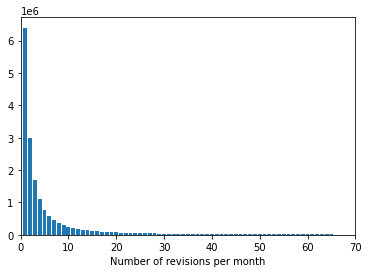

In [12]:
data_user_revisions_per_month = df_english['revisions'].value_counts()

fig, ax = plt.subplots()

ax.bar(data_user_revisions_per_month.index, data_user_revisions_per_month.values)
ax.set(xlim=(0, 70))
plt.xlabel('Number of revisions per month')
plt.show()


We see that median number of revisions by a user per month is 2. However, the average number of revisions by a user per month is 28.7. This data is incredibly right skewed. Indeed, we see from this histogram that the distribution has a heavy right tail. In particular we have an extreme outlier with a the max number of revsions in a given month by an individual user being nearly 2 million (exactly 1,712,735 revisions). Let's investigate this outlier further by looking at who the culprit is.

In [13]:
df_english.loc[df_english['revisions'].idxmax()]

month                2013-03-01 00:00:00
user_id                          6569922
user_name                         Addbot
user_name_has_bot                   True
user_registration    2008-03-01 00:00:00
archived                          5968.0
non_archived                   1706767.0
revisions                      1712735.0
attached_method                  primary
Name: 14288828, dtype: object

We see that `user_id` 6569922 has `user_name` `Addbot`. It's a bot! It makes sense that some bot could make that many revisions in a given month. A quick calculation shows thats about 39 revisions per minute for an entire month.

Now we consider the trend of user registrations. Namely, we plot the number of new user registrations per month.

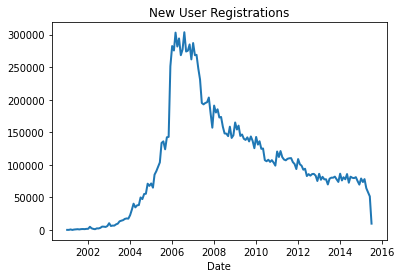

In [14]:
data_user_registration =  df_english['user_registration'].value_counts().sort_index()

fig, ax = plt.subplots()

ax.plot(data_user_registration.index, data_user_registration.values, linewidth=2.0)
plt.xlabel('Date')
plt.title('New User Registrations')
plt.show()

Now we plot the cumulative new users per month.

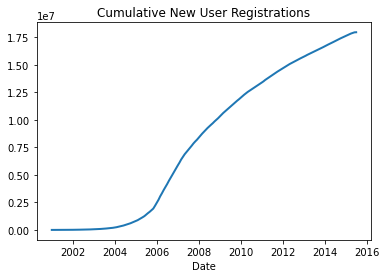

In [15]:
data_user_registration_cumulative =df_english['user_registration'].value_counts().sort_index().cumsum()

fig, ax = plt.subplots()

ax.plot(data_user_registration_cumulative.index, data_user_registration_cumulative.values, linewidth=2.0)
plt.xlabel('Date')
plt.title('Cumulative New User Registrations')
plt.show()

We see that in 2006 there is a significant spike in the total number of new registered users. This is prepresentative in both plots above. Note that from 2006-2007 the number of new register users appear to plateu with a decline afterwards. It interesting to explore why there is this behavior in the trend. Some natrual questions:
* Did wikipedia some how become more accessable? I.e. Was there some software update at that time? Did people have easier access to wikipedia with smartphones etc?
* Did wikipedia become more popular? I.e. was there some reference to in news?
* A combination of both?

### Edit Trend

We now plot the trend total number of edits per month. Shown below we plot `non_archived`, `archived`, and `revisions` with respect to the month.

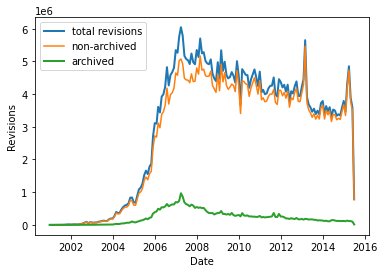

In [16]:
data_non_archived = df_english.groupby('month')['non_archived'].sum()
data_archived = df_english.groupby('month')['archived'].sum()
data_revisions = df_english.groupby('month')['revisions'].sum()

fig, ax = plt.subplots()

ax.plot(data_revisions.index, data_revisions.values, linewidth=2.0)
ax.plot(data_non_archived.index, data_non_archived.values)
ax.plot(data_archived.index, data_archived.values, linewidth=2.0)

ax.legend(['total revisions','non-archived', 'archived'])
plt.xlabel('Date')
plt.ylabel('Revisions')

plt.show()

Interestingly enough, but to no suprise, there is a sharp increase near 2006. This is expected when considering that there was a large increase of new user registrations near the same time.

We suspect that bots are more active than organic users. So we now consider a smiliar plot, however we differenatie between those with `bot` in their username vs those without.

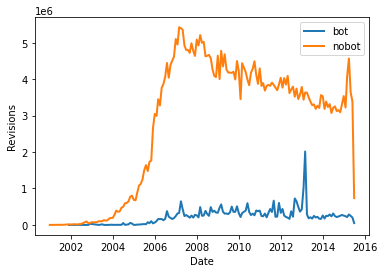

In [17]:

data_revisions = df_english[ df_english['user_name_has_bot']==False].groupby('month')['revisions'].sum()
data_revisions_bot = df_english[ df_english['user_name_has_bot']==True].groupby('month')['revisions'].sum()

fig, ax = plt.subplots()

ax.plot(data_revisions_bot.index, data_revisions_bot.values, linewidth=2.0)
ax.plot(data_revisions.index, data_revisions.values, linewidth=2.0)
        
ax.legend(['bot','nobot'])
plt.xlabel('Date')
plt.ylabel('Revisions')

plt.show()
    

This seems to contradict our expectation that bots are more prolific than organic users. That is, the plot above suggests that the total number of revisions made to wikipedia are mad by organic users rather than bots.